# Classification with Logistic Regression

In the present work an implementation of Logistic regression for image classification will be presented. That would be done in the following steps:

1. Explain what Logistic Regression is
2. Define the Cost function
3. Minimize the Cost function using Gradient descent
4. Apply Principal component analysis (PCA)
5. Train the model
6. Evaluate the model
7. Compare with Scikit-learn



## Machine learning basics

ML algorithms are usually divided into two main groups: $Supervised$ and $Unsupervised$. 

### Supervised Machine Learning

The training data contains the desired outputs called targets or labels. Typical examples are linear regression, usually used for prediction of numerical values, and logistic regression, used for classification.

#### When we need to answer questions like:
* Given the description of an apartment, what is the expected market value of the flat? What will the value be if the apartment has an elevator?
* Given the past records of user activity on Apps, how long will a certain client be connected to our App?
* Given my skills and marks in computer science and maths, what mark will I achieve in a data science course? [7],
then this is a typical regression problem. Some value has to be forecasted/predicted based on available data (sometimes historical). 

Below is the representation of data and its linear regression model taken from Wikipedia.

![LinRegr](LinReg.JPG)


The red line is the approximation of the data and for one independednt variable $x$, the dependent variable $y$ will look like: $y=\theta_0+\theta_1*x_1$. If we have more independent variables (called features) $x_1,x_2,...,x_n$ then $y=\theta_0+\theta_1*x_1+\theta_2*x_2+...+\theta_n*x_n$


#### Should the answers to our questions are "YES/NO", 
then we have to use classification algorithms. More generally speaking, classifiers are used when the answers belong to a finite discrete value range [7].
* Given the results of a clinical test, e.g., does this patient suffer from diabetes?
* Given a magnetic resonance image, is it a tumor shown in the image?
* Given the past activity associated with a credit card, is the current operation fraudulent?





### Unsupervised Machine Learning

For this type of algorithms, the input data is not labeled. We expect the machine to learn and discover itself any relationships and patterns in the data. Another difference from supervised methods is that there is no error function, since there is nothing to be compared to. According to the tasks they perform, the unsupervised ML algorithms can be divided into the following groups [7]: 

* Clustering: has as a goal to partition the set of examples into groups.
* Dimensionality reduction: aims to reduce the dimensionality of the data. Here, we encounter techniques such as Principal Component Analysis (PCA), independent component analysis, and nonnegative matrix factorization.
* Outlier detection: has as a purpose to find unusual events (e.g., a malfunction), that distinguish part of the data from the rest according to certain criteria.
* Novelty detection: deals with cases when changes occur in the data (e.g., in streaming data).

Popular algorithms are K-Nearest Neighbors (KNN), K-Means Clustering, Principal Components Analysis (PCA).




## Model development

I chose to illustrate the application of Logistic regression for recognizing cats and dogs, i.e. classifying the images into two categories (classes). The dataset is taken from https://www.kaggle.com/biaiscience/dogs-vs-cats. It contains a training set of 12500 pics of dogs and 12500 pics of cats. And a test set of 12500 not classified pictures.

A lot of articles on the topic can be found on the Internet. Many models have been developed to solve the issue. This is a very classical and basic application of logistic regression. Some examples are: [Messy vs. Clean Room](https://www.kaggle.com/gulsahdemiryurek/image-classification-with-logistic-regression) and [Cats vs. Dogs](http://saurabhg.com/machine-learning/solution-to-kaggles-dogs-vs-cats-challenge-using-logistic-regression/). In the first one a very high test accuracy has been decraled (93.75%), which I was not able to achieve. The second work gives results which are close to what I got with my model 58-62%.

Let's first write the functions for importing the data and then we will look into the theory of logistic regression. 

### Import the data

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import cv2
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import os
import scipy.stats as st


In [3]:
# this is the folder with training data which is labeled

training_folder='C:/SU/Project/dogs-vs-cats/train/'

# folder with unlabeled test data

test_folder='C:/SU/Project/dogs-vs-cats/test1/'

An image is a 2D array (i.e. matrix) of pixels. If it's grayscale, each pixel will be an integer from 0 to 255 [4]: 

$$ I=\begin{bmatrix}
20 & 45 & 83 & \dots \\
38 & 182 & 200 & \dots \\
\dots & \dots & \dots & \dots \\
\end{bmatrix} $$

In an RGB image, each pixel contains three values, corresponding to  𝑅 ,  𝐺  and  𝐵. In order to set properly the data to feed it to the algorithm, we have to present each pixel as a feature, or a column in a matrix and each picture as a sample, or row in the same matrix. For this purpose, we will use the function flatten(), so the 2D/3D array of each image is transformed into a row vector. Then we divide each value in the input matrix by 255 in order to normalize the values. This is necessary for getting the feature values into the same range, leading to a better accuracy. Also labeling of each row (sample) is performed by concatenating (appending) "1" (for cat) or "0" (for dog) at each row. 

In [4]:
def import_pictures(image_size):

    
    cat_images=[]
    dog_images=[]

    for file in os.listdir(training_folder):
        if 'cat' in file:
            
            img_cat=cv2.imread(training_folder+str(file),cv2.IMREAD_COLOR)
            img_cat_resized=cv2.resize(img_cat,(image_size,image_size)).flatten()/255
            img_cat_labeled=np.append(img_cat_resized,1)
            cat_images.append(img_cat_labeled)
        
        if 'dog' in file:
        
            img_dog=cv2.imread(training_folder+str(file),cv2.IMREAD_COLOR)
            img_dog_resized=cv2.resize(img_dog,(image_size,image_size)).flatten()/255
            img_dog_labeled=np.append(img_dog_resized,0)
            dog_images.append(img_dog_labeled)
    
    cat_images=np.array(cat_images)
    dog_images=np.array(dog_images)
    
    return cat_images,dog_images

Here are some samples of our cuties.

![A cat](cat.1.jpg)
![A dog](dog.28.jpg)

Now we will take the cats and dogs pictures from the labeled arrays and concatenate them. We also have to add a first column of "ones" for $x_0$ which is multiplied by $\theta_0$. Since cats and dogs are grouped together, it is good to shuffle the matrix rows. This would make sure that train and test sets are representative of the overall data distribution. 

The final step in data preparation is to split the data into training set which will be used to train the model and a test set which will be used to check its accuracy and performance on unseen data. This is done by sklearn function train_test_split().

In [5]:
def take_data_subset(temp_size,cat_images,dog_images,n_components):
    
    #temp_size is the number of pictures (samples) to be taken from the set
    
    temp_cat=cat_images[:temp_size,:]
    temp_dog=dog_images[:temp_size,:]
    temp_training_set=np.concatenate((temp_cat,temp_dog),axis=0)
     
    np.random.shuffle(temp_training_set)
        
    X_train,X_test,y_train,y_test,expl_var_rt=apply_PCA(temp_training_set,n_components) # apply_PCA function is defined and explained little bit later
        
    return X_train,X_test,y_train,y_test,expl_var_rt

### Logistic Regression

The following assumptions are made when using logistic regression:

1. Minimum or no multicollinearyty among the independent variables.
2. Independent variables are linearly related to the log of odds.
3. Sample size is large.
4. Logistic regression which has 2 classes assumes that the dependent variable is binary and ordinary logistic regression requires the dependent variable to be ordered.
5. Observations are independent.

This algorithm is commonly used for classification purposes because it can estimate the probability of an instance belonging to a specific category. The simplest type is the binary logistic regression where we have only two categories (or classes). Usually, they are denoted by "1" and "0". The logic is that if the estimated probability is above 50% then the model predicts that the sample belongs to a specified class, usually considered the positive one and denoted by "1". And vise versa.

In order for such an algorithm to work properly, a suitable activation function is needed. Again, as in Linear Regression, a weighted sum of the input features is calculated but instead of outputting the result directly, it is submitted to a sigmoid function $\sigma(z)$:

$$\sigma(z)=\frac{1}{1+e^{-z}}$$

This function outputs a number between 0 and 1 and is defined in the range ${(-\infty}$ ${+\infty)}$.
If we have the array X of our input data and ${\theta}$ of the feature weights, then ${z=X*\theta}$

$$X=\left\lgroup \matrix{x_{11}&x_{12}&\cdots&x_{1n} \\ x_{21}&x_{22}&\cdots&x_{2n} \\ \vdots&\vdots&\ddots&\vdots \\ x_{m1}&x_{m2}&\cdots&x_{mn}} \right\rgroup$$

$$\theta=\left\lgroup \matrix{\theta_1 \\ \theta_2 \\ \vdots \\ \theta_n}\right\rgroup$$

X has dimentionality m x n: m samples, n features.

In order to take into account of the intercept we have to add $\theta_0$ and in order to do vector/matrix multiplication and addition we also have to add one more column in X (for $x_0)$, a column of all ones which will multiply $\theta_0$. So X and $\theta$ matrices will look like this:

$$X=\left\lgroup \matrix{1&x_{11}&x_{12}&\cdots&x_{1n} \\ 1&x_{21}&x_{22}&\cdots&x_{2n} \\ \vdots&\vdots&\ddots&\vdots \\ 1&x_{m1}&x_{m2}&\cdots&x_{mn}} \right\rgroup$$

$$\theta=\left\lgroup \matrix{\theta_0 \\ \theta_1 \\ \theta_2 \\ \vdots \\ \theta_n}\right\rgroup$$

Then our hypothesis for the $i^{-th} sample$ will be: $$h_{\theta}(x^{i}) \ \ = \ \ 1*\theta_0+x_{i1}*\theta_1+x_{i2}*\theta_2+\cdots+x_{in}*\theta_n$$


With y we will denote the outcomes (classes).

The function $ \ \ h_{\theta}(x) \ \ = \ \ \sigma(z) \ \ = \sigma(X*\theta)$ we will denote as the hypothesis of our predictions.

So the sigmoid for logistic regression will look like this: $$\sigma(z)=\frac{1}{1+e^{-\theta*X}}$$


Below we will define the sigmoid function that will be further used in the model and show how it looks.



In [6]:
def sigmoid(z):
    return 1/(1+(np.power((np.e),-z)))

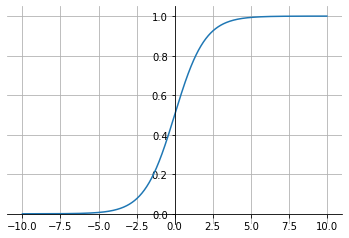

In [7]:
z=np.linspace(-10,10,1000)
y=sigmoid(z)
plt.plot(z,y)
plt.grid()
ax = plt.gca()
ax.spines["bottom"].set_position("zero")
ax.spines["left"].set_position("zero")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

Once the model has estimated the probablity $\hat{p}=h_{\theta}(x) $, it can make its prediction $\hat{y}$ as following:
$$\hat{y}=\Bigg\{ \matrix{1 \ \ if \ \ \hat{p}\ \ \geqslant	\ \ 0.5 \\ 0 \ \ if \ \ \hat{p}\ \ < \ \ 0.5}$$


From the graph above, we can see that $\ \ \sigma(z) \ \ < 0.5 \ \ $ when $\ \ z \ \ < \ \ 0 \ \ $  and $\ \ \sigma(z) \ \ \geqslant \ \ 0.5 \ \ $ when $\ \ z \ \ \geqslant \ \ 0$









In order to be able to make any predictions using Logistic Regression, we need to train the model. For that we have to define the cost function, or error, which we will later try to minimize in order to get a more accurate model.

### Cost Function

The cost function $J(\theta)$ shows the difference between model hypothesis and actual class of the training samples. This function is used for training the model. The goal is to find the weighting parameters $\theta$ values for which the cost function is minimal. For logistinc regression it looks like this:

$ \text{J}(\theta) \ \ = \ \  \text{Cost}(h_{\theta}(x),y)=\Bigg\{ \matrix{{- \text {log}(h_{\theta}(x)) \ \ if \ \ y=1} \\ {- \text{log}(1-h_{\theta}(x)) \ \ if \ \ y=0}}$

In the graph below we can see that:

-log(x) grows very much when x approaches 0, so the cost will be large if the model estimates 0 when the actual class is 1. On the other hand, -log(1-x) grows fast as x approaches 1 and the cost will be big if the model predicts 1 when the actual value is 0.


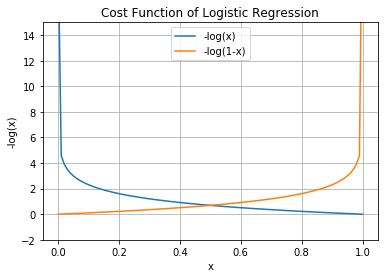

In [8]:
x1=np.linspace(0.000000001,1,100)
y1=-np.log(x1)
plt.plot(x1,y1,label="-log(x)")
x2=np.linspace(0,1,100)
y2=-np.log(1-x2+0.000000000001)
plt.plot(x2,y2,label="-log(1-x)")
plt.grid()
plt.legend()
plt.ylim(-2,15)
plt.ylabel("-log(x)")
plt.xlabel("x")
plt.title("Cost Function of Logistic Regression")
plt.show()

Combining the above in one equation we get:

$\ Cost(h_{\theta}(x),y) \ \ = \ \ -y*\log(h_{\theta}(x)) \ \ - \ \ (1-y)*\log(1-h_{\theta}(x))$

Over the whole training set it is the average cost over all tarining instances.

$\text Cost(h_{\theta}(x),y) \ \ = \ \ -\frac{1}{m}\sum_{i=1}^m[y^{i}\log(h_{\theta}(x^{i}) \ \ + \ \ (1-y^{i})\log(1-h_{\theta}(x^{i}))]$

where $i$ is the $i^{-th}$ sample.

Good thing about this function is that it is convex, meaning, it has one global minimum which we will have to find.

One of the popular algorithms used for optimizing this function is Gradient Descent.


### Gradient Descent

The idea behind GD is that it is changing values of $\theta$s so that it finds the minimum of the Cost function $J(\theta)$. In order to change each $\theta$ in the correct direction, the algorithm uses partial derivatives of $J(\theta)$ with respect to each separate $\theta$. 

$$\frac{\partial J(\theta_0,\theta_1,\cdots,\theta_n)}{\partial\theta_j} \ \ = \frac{\partial}{\partial\theta_j}\frac{1}{2m}\sum_{i=1}^m (h_{\theta}(x^{(i)}-y^{(i)})^2$$
i is th $i^{-th}$ sample out of total of m samples.

Each derivative will show the direction of fastest function growth. The algorithm will then take the reverse direction because it is searching for the decrease direction. After performing the calculations we get:
$$\frac{\partial J(\theta)}{\partial\theta_j}=\frac{1}{m}\sum_{i=1}^m(h_{\theta}(x^{(i)}-y^{(i)}).x_{j}^{(i)}$$

For $\theta_0, \ \ x_0^{(i)}=1$ 

Having found the partial derivatives, the values of $\theta$ are updated as following:

$$\theta_j=\theta_j-\alpha.\frac{\partial}{\partial\theta_j}J(\theta)$$

$\alpha$ is a parameter of the GD called learning rate. Its values determine how quickly the algorithm converges to the minimum. If we choose small $\alpha$ the GD will be slow but there will be little or no risk of missing the minimum. While having big value of $\alpha$ will speed up the algorithm but then it might miss the minimum and there will be no convergence. Different values should be tested in order to choose the best one. 

It is important to update all $\theta$s simultaneously.

Below, is the function which takes as input parameters theta, X_train, y_train, alpha and number of iterations (for reaching the minimum of the cost function), calculates the cost function, its partial derivatives, updates $\theta$ values and returns the "trained" theta values and cost value.

In [37]:
def gradient_descent(theta,X_train,y_train,alpha,num_iterations):
    
    
    cost_list=[]
    cost=0
    
    lmbda=0.1
    
    for iteration in range(num_iterations):
        
        hypothesis=sigmoid(np.dot(X_train,theta))
        nb_samples=X_train.shape[0]
        cost+=np.sum((y_train*np.log(hypothesis+0.00000001)+(1-y_train)*np.log(1-hypothesis+0.00000001)))
        
        cost=-cost/nb_samples
        cost_list.append(cost)
        theta1=theta
        theta1[0]=0
        
        derivative=(1/nb_samples)*(np.dot(X_train.T,(hypothesis-y_train))) +(lmbda/nb_samples)*theta1
         
        theta=theta-alpha*derivative
       
        #print (iteration,":",cost)   
    x=np.arange(num_iterations)
    plt.plot(x,cost_list)
    plt.xlabel("Iterations")
    plt.ylim(ymin=0,ymax=1)
    plt.ylabel("Cost")
    plt.show()
    
    return (theta,cost)

The term (lmbda/nb_samples)*theta1 is used for regularisation (decrease the influence of $\theta$ parameters) in order to fight overfitting. I tried with several values of lambda but didn't notice any effect.

### Primary Components Analysis (Dimensionality reduction)

When we import pictures, taking even a small size color image of 64x64 pixels will give 64x64x3=12288 pixels in total. Which is the number of features. In our case we have 25000 images of cats and dogs together. That will result in overfitting. In order to evade that, we need the number of samples to be substantially bigger than the number of features. One option is to further reduce the image size, i.e. 32x32 pixels and/or make it gray scale, which will reduce the number of features by a factor of 3. Another option is to use some algorithm for dimentionality reduction. My experiments for this assignment showed that it is better to import images in color and then apply dementionality reduction using PCA.

The description of PCA I will take from [5].

PCA is a technique for dimensionality reduction. Vectors are defined to represent the dataset and they are ordered by successive importance, so they can reconstruct an approximate representation using few components.

The principal components define the axes of an ellipsoid best fitting the points (fig. 1). 

![Fig1](Fig1.JPG)
The origin of this set of axes is the centroid of the points. PCA starts by identifying the direction to project the points on to so as to explain the maximum amount of variance. This is the line through the centroid that, in some sense, best fits the points, making it analogous to linear regression. We can then project each point onto this line, with this point of intersection defining a particular position on the line relative to the centroid. These projected positions now define the first dimension (or principal component) of our new representation (fig. 2). The direction of the lines is actually the direction of the eigenvectors of the covariance matrix of data features. This matrix being symmetrical, means that every primary component will be orthogonal to all other PCs.

![Fig2](Fig2.JPG)

For each subsequent component, we seek the line $l_k$, which is orthogonal to all previous lines and explains the largest amount of the remaining variance. That each dimension is orthogonal to each other means they act like coordinate axes, establishing the connection to eigenvectors. Each subsequent dimension is progressively less important than the ones before it, because we chose the most promising directions first. Later components contribute only progressively finer detail, and hence we can stop once this is small enough.

PCA constructs new dimensions as linear combinations of the original ones, collapsing those which are highly correlated into a lower-dimensional space. Statistical factor analysis is a technique which identifies the most important orthogonal dimensions (as measured by correlation) that explain the bulk of the variance. Relatively few components suffice to capture the basic structure of the point set. The residual that remains is likely to be noise, and is often better off removed from the data. After dimension reduction via PCA, we should end up with cleaner data, not merely a smaller number of dimensions.

In order to choose how many primary components to use, we should draw the explaind variance with respect to the number of primary components used. Depending on the application, 90 - 95 % should be enough to represent the data without much loss.


In [10]:
def apply_PCA(temp_training_set,n_components):
    
    
    X=temp_training_set[:,:-1]
    y=np.array([temp_training_set[:,-1]]).T
    
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.10,random_state=42)
    
    
    pca=decomposition.PCA(n_components)
    
    # the pca is fit only to the training set, otherwise it will "see" the test set
    # after that transform is applied to both trainigna nd test sets
    
    pca.fit(X_train)
    pca_temp_training_set=pca.transform(X_train)
    pca_temp_test_set=pca.transform(X_test)
    
    
    print ("Expl variance for ",n_components," components: ",round(np.sum(pca.explained_variance_),2))
    print ("Expl variance ratio for ",n_components," components: ",round(np.sum(pca.explained_variance_ratio_),2))
        
    
    #pca_temp_set_final=np.concatenate((pca_temp_training_set,pca_temp_test_set),axis=0)
    
    ones_vector=np.ones((pca_temp_training_set.shape[0],1))
    pca_temp_training_set=np.c_[ones_vector, pca_temp_training_set]  
    
    ones_vector=np.ones((pca_temp_test_set.shape[0],1))
    pca_temp_test_set=np.c_[ones_vector, pca_temp_test_set]  

    #pca_temp_set_final=np.c_[ones_vector, pca_temp_set_final]  
    
    expl_var_rt=np.sum(pca.explained_variance_ratio_)
   
    return pca_temp_training_set,pca_temp_test_set,y_train,y_test,expl_var_rt
    

After we have trained the model and calculated the best theta parameters (theta_trained), it is time to start predictions.

In [11]:
def predict(theta_trained,X_test):
    
    hypothesis=np.dot(X_test,theta_trained)
    y_predicted=sigmoid(hypothesis)
    y_predicted_res=[1 if i>=0.5 else 0 for i in y_predicted]
    
    return y_predicted_res

### Evaluation of the model

Now we will run the model, test it and evaluate.
A few words about evaluating logistic regression.

When evaluating classifiers, we usually measure the number of correctly classified instances. A convenient way to do this is to use the so called Confusion matrix. It is especially useful when we have imbalanced dataset.
![Confusion Matrix](CM.JPG)

In binary classification there are four possible outcomes:
   * True Positives (TP) - positives correctly identified as positives
   * True Negatives (TN) - negatives correctly identified as negatives 
   * False Positives (FP) - negatives identified as positives
   * False Negatives (FN) - positives identified as negatives

There are several evaluation statistics that can be computed from the counts above:

$$Accuracy \ \ = \ \ \frac{TP+TN}{TP+TN+FP+FN} \\ $$

$$Precision \ \ = \ \ \frac{TP}{TP+FP} $$
$$Recall (Sensitivity) \ \ = \ \ \frac{TP}{TP+FN} $$

$$Specificity \ \ = \frac{TN}{TN+FP}$$

$$Negative Predictive Value \ \ \frac{TN}{TN+FN}$$

$$F-score \ \ = 2.\frac{precision.recall}{precision+recall}$$

The upper mentioned evaluation metrics describe the performance of the classifier. In order to evaluate the learning algorithm itself, the so called "learning curve" is used. It shows the training and test error vs. the number of samples in the dataset. Theoretically it should look like [7]:

![Learning curve](Learn_curve.JPG)



In [12]:
def run_the_model(image_size,dataset_size,n_components,alpha,num_iterations):
    
   
    cats,dogs=import_pictures(image_size)
    X_train,X_test,y_train,y_test,expl_var_rt=take_data_subset(dataset_size,cats,dogs,n_components)
   
    theta=np.zeros([X_train.shape[1],1]) #initializing theta
    
    theta_trained,cost=gradient_descent(theta,X_train,y_train,alpha,num_iterations)
    
    cost_list.append(cost) #appending the cost value at each iteration
    
    y_predicted_test=predict(theta_trained,X_test) # predicting y with the test set
    y_predicted_train=predict(theta_trained,X_train) #prdicting y with the training set
    
    
    acc_test.append(round(metrics.accuracy_score(y_predicted_test,y_test),2))
    acc_train.append(round(metrics.accuracy_score(y_predicted_train,y_train),2))
    err_test.append(round(1-metrics.accuracy_score(y_predicted_test,y_test),2))
    err_train.append(round(1-metrics.accuracy_score(y_predicted_train,y_train),2))
    
    #calculating the confusion matrix and related metrics
    
    TP=np.sum(np.logical_and(np.array([y_predicted_test]).T==1,y_test==1))
    TN=np.sum(np.logical_and(np.array([y_predicted_test]).T==0,y_test==0))
    FP=np.sum(np.logical_and(np.array([y_predicted_test]).T==1,y_test==0))
    FN=np.sum(np.logical_and(np.array([y_predicted_test]).T==0,y_test==1))
    
    Accuracy=round((TP+TN)/(TP+TN+FP+FN),2)
    Precision=round(TP/(TP+FP),2)
    Recall=round(TP/(TP+FN),2)
    F_score=round(2*Precision*Recall/(Precision+Recall),2)
    
    print ("Error: ",round(1-metrics.accuracy_score(y_predicted_test,y_test),2))
    print ()
    print ("Confusion matrix: ")
    print ("TP: ",TP," TN: ",TN)
    
    print ("FP: ",FP," FN: ",FN)
    print ()
    print ("Accuracy = ", Accuracy)
    print ("Precision = ", Precision)
    print ("Recall = ", Recall)
    print ("F-score = ", F_score)
    print ()
    
    return expl_var_rt,theta_trained


Now I will run the model for different number of primary components in order to determine how many of them are enough to properly represent the features.

In [13]:
cost_list=[]
acc_test=[]
acc_train=[]
err_test=[]
err_train=[]
expl_var_rt_list=[]

------------------------------
Number of PCs:  50
Expl variance for  50  components:  152.24
Expl variance ratio for  50  components:  0.75


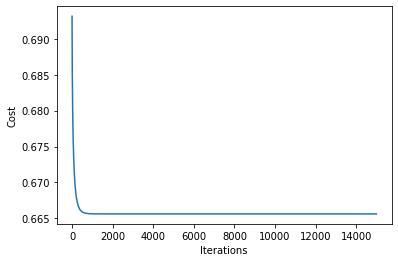

Error:  0.41

Confusion matrix: 
TP:  728  TN:  735
FP:  539  FN:  498

Accuracy =  0.59
Precision =  0.57
Recall =  0.59
F-score =  0.58

Train Accuracy:  [0.59]
Test Accuracy:  [0.59]
------------------------------
Number of PCs:  100
Expl variance for  100  components:  165.37
Expl variance ratio for  100  components:  0.81


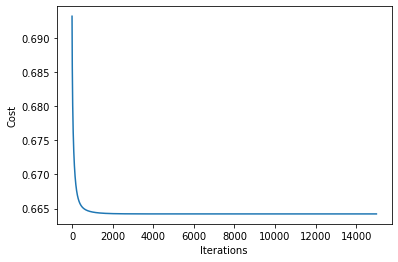

Error:  0.4

Confusion matrix: 
TP:  748  TN:  742
FP:  509  FN:  501

Accuracy =  0.6
Precision =  0.6
Recall =  0.6
F-score =  0.6

Train Accuracy:  [0.59, 0.6]
Test Accuracy:  [0.59, 0.6]
------------------------------
Number of PCs:  150
Expl variance for  150  components:  172.18
Expl variance ratio for  150  components:  0.85


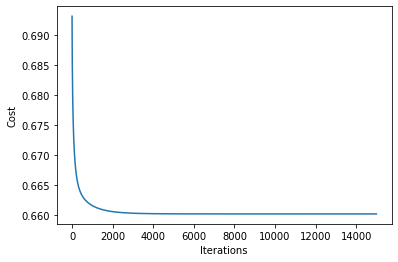

Error:  0.41

Confusion matrix: 
TP:  743  TN:  732
FP:  525  FN:  500

Accuracy =  0.59
Precision =  0.59
Recall =  0.6
F-score =  0.59

Train Accuracy:  [0.59, 0.6, 0.6]
Test Accuracy:  [0.59, 0.6, 0.59]
------------------------------
Number of PCs:  200
Expl variance for  200  components:  176.12
Expl variance ratio for  200  components:  0.87


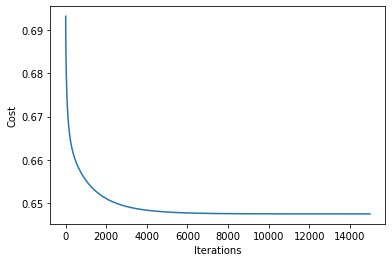

Error:  0.37

Confusion matrix: 
TP:  823  TN:  756
FP:  478  FN:  443

Accuracy =  0.63
Precision =  0.63
Recall =  0.65
F-score =  0.64

Train Accuracy:  [0.59, 0.6, 0.6, 0.63]
Test Accuracy:  [0.59, 0.6, 0.59, 0.63]
------------------------------
Number of PCs:  250
Expl variance for  250  components:  179.79
Expl variance ratio for  250  components:  0.89


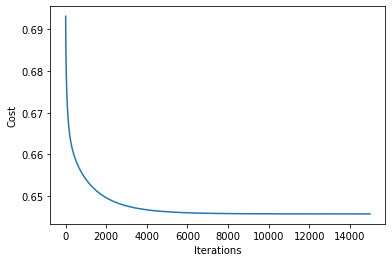

Error:  0.39

Confusion matrix: 
TP:  804  TN:  727
FP:  502  FN:  467

Accuracy =  0.61
Precision =  0.62
Recall =  0.63
F-score =  0.62

Train Accuracy:  [0.59, 0.6, 0.6, 0.63, 0.63]
Test Accuracy:  [0.59, 0.6, 0.59, 0.63, 0.61]
------------------------------
Number of PCs:  300
Expl variance for  300  components:  182.14
Expl variance ratio for  300  components:  0.9


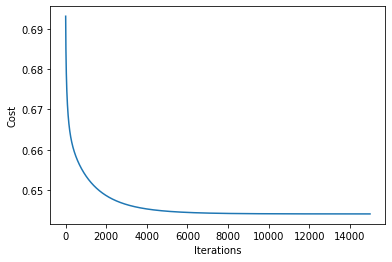

Error:  0.39

Confusion matrix: 
TP:  785  TN:  747
FP:  520  FN:  448

Accuracy =  0.61
Precision =  0.6
Recall =  0.64
F-score =  0.62

Train Accuracy:  [0.59, 0.6, 0.6, 0.63, 0.63, 0.63]
Test Accuracy:  [0.59, 0.6, 0.59, 0.63, 0.61, 0.61]
------------------------------
Number of PCs:  350
Expl variance for  350  components:  184.48
Expl variance ratio for  350  components:  0.91


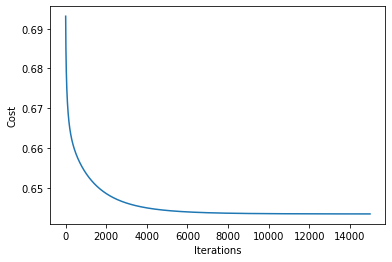

Error:  0.4

Confusion matrix: 
TP:  754  TN:  756
FP:  506  FN:  484

Accuracy =  0.6
Precision =  0.6
Recall =  0.61
F-score =  0.6

Train Accuracy:  [0.59, 0.6, 0.6, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.59, 0.6, 0.59, 0.63, 0.61, 0.61, 0.6]
------------------------------
Number of PCs:  400
Expl variance for  400  components:  186.21
Expl variance ratio for  400  components:  0.92


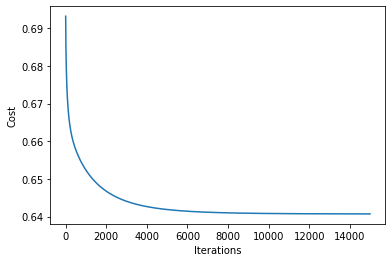

Error:  0.39

Confusion matrix: 
TP:  797  TN:  725
FP:  533  FN:  445

Accuracy =  0.61
Precision =  0.6
Recall =  0.64
F-score =  0.62

Train Accuracy:  [0.59, 0.6, 0.6, 0.63, 0.63, 0.63, 0.63, 0.64]
Test Accuracy:  [0.59, 0.6, 0.59, 0.63, 0.61, 0.61, 0.6, 0.61]
------------------------------
Number of PCs:  450
Expl variance for  450  components:  188.06
Expl variance ratio for  450  components:  0.93


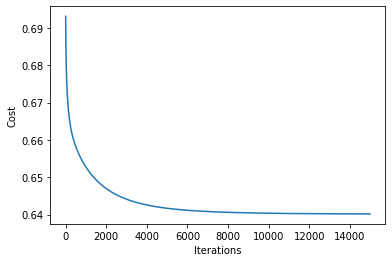

Error:  0.38

Confusion matrix: 
TP:  770  TN:  782
FP:  484  FN:  464

Accuracy =  0.62
Precision =  0.61
Recall =  0.62
F-score =  0.61

Train Accuracy:  [0.59, 0.6, 0.6, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64]
Test Accuracy:  [0.59, 0.6, 0.59, 0.63, 0.61, 0.61, 0.6, 0.61, 0.62]
------------------------------
Number of PCs:  500
Expl variance for  500  components:  189.96
Expl variance ratio for  500  components:  0.94


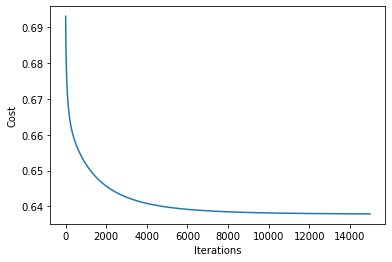

Error:  0.39

Confusion matrix: 
TP:  790  TN:  743
FP:  521  FN:  446

Accuracy =  0.61
Precision =  0.6
Recall =  0.64
F-score =  0.62

Train Accuracy:  [0.59, 0.6, 0.6, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64, 0.64]
Test Accuracy:  [0.59, 0.6, 0.59, 0.63, 0.61, 0.61, 0.6, 0.61, 0.62, 0.61]
------------------------------
Number of PCs:  550
Expl variance for  550  components:  191.06
Expl variance ratio for  550  components:  0.94


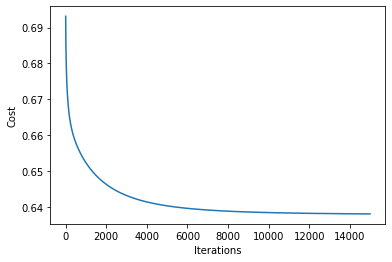

Error:  0.37

Confusion matrix: 
TP:  781  TN:  789
FP:  448  FN:  482

Accuracy =  0.63
Precision =  0.64
Recall =  0.62
F-score =  0.63

Train Accuracy:  [0.59, 0.6, 0.6, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64, 0.64, 0.64]
Test Accuracy:  [0.59, 0.6, 0.59, 0.63, 0.61, 0.61, 0.6, 0.61, 0.62, 0.61, 0.63]
------------------------------
Number of PCs:  600
Expl variance for  600  components:  192.84
Expl variance ratio for  600  components:  0.95


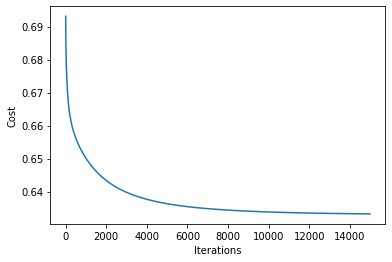

Error:  0.39

Confusion matrix: 
TP:  768  TN:  766
FP:  501  FN:  465

Accuracy =  0.61
Precision =  0.61
Recall =  0.62
F-score =  0.61

Train Accuracy:  [0.59, 0.6, 0.6, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64, 0.64, 0.64, 0.64]
Test Accuracy:  [0.59, 0.6, 0.59, 0.63, 0.61, 0.61, 0.6, 0.61, 0.62, 0.61, 0.63, 0.61]
------------------------------
Number of PCs:  650
Expl variance for  650  components:  193.28
Expl variance ratio for  650  components:  0.95


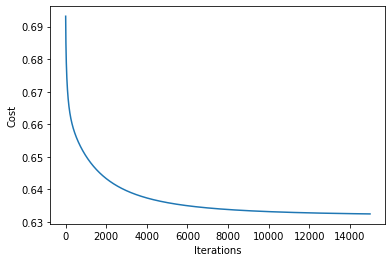

Error:  0.39

Confusion matrix: 
TP:  800  TN:  733
FP:  492  FN:  475

Accuracy =  0.61
Precision =  0.62
Recall =  0.63
F-score =  0.62

Train Accuracy:  [0.59, 0.6, 0.6, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64]
Test Accuracy:  [0.59, 0.6, 0.59, 0.63, 0.61, 0.61, 0.6, 0.61, 0.62, 0.61, 0.63, 0.61, 0.61]
------------------------------
Number of PCs:  700
Expl variance for  700  components:  194.68
Expl variance ratio for  700  components:  0.96


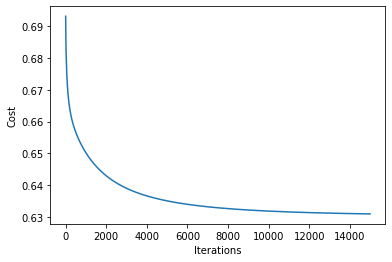

Error:  0.4

Confusion matrix: 
TP:  821  TN:  691
FP:  524  FN:  464

Accuracy =  0.6
Precision =  0.61
Recall =  0.64
F-score =  0.62

Train Accuracy:  [0.59, 0.6, 0.6, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.65]
Test Accuracy:  [0.59, 0.6, 0.59, 0.63, 0.61, 0.61, 0.6, 0.61, 0.62, 0.61, 0.63, 0.61, 0.61, 0.6]
------------------------------
Number of PCs:  750
Expl variance for  750  components:  195.95
Expl variance ratio for  750  components:  0.96


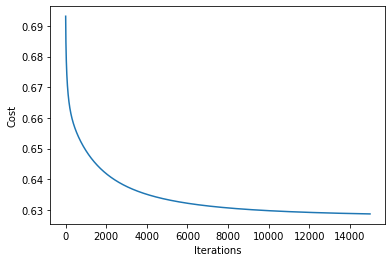

Error:  0.39

Confusion matrix: 
TP:  767  TN:  749
FP:  542  FN:  442

Accuracy =  0.61
Precision =  0.59
Recall =  0.63
F-score =  0.61

Train Accuracy:  [0.59, 0.6, 0.6, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.65, 0.65]
Test Accuracy:  [0.59, 0.6, 0.59, 0.63, 0.61, 0.61, 0.6, 0.61, 0.62, 0.61, 0.63, 0.61, 0.61, 0.6, 0.61]
------------------------------
Number of PCs:  800
Expl variance for  800  components:  196.65
Expl variance ratio for  800  components:  0.97


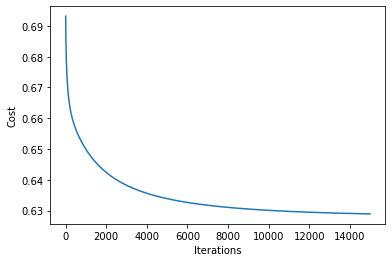

Error:  0.4

Confusion matrix: 
TP:  774  TN:  720
FP:  545  FN:  461

Accuracy =  0.6
Precision =  0.59
Recall =  0.63
F-score =  0.61

Train Accuracy:  [0.59, 0.6, 0.6, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.65, 0.65, 0.65]
Test Accuracy:  [0.59, 0.6, 0.59, 0.63, 0.61, 0.61, 0.6, 0.61, 0.62, 0.61, 0.63, 0.61, 0.61, 0.6, 0.61, 0.6]


In [14]:
image_size=32
dataset_size=12500
alpha=0.02 #learning rate
num_iterations=15000

for i in range(50,850,50):
    print ("-"*30)
    print ("Number of PCs: ",i)
    
    n_components=i
    expl_var_rt,theta_trained=run_the_model(image_size,dataset_size,n_components,alpha,num_iterations)
    expl_var_rt_list.append(expl_var_rt)
    print ("Train Accuracy: ",acc_train)
    print ("Test Accuracy: ",acc_test)
    


Now, let's plot the explained variance ratio. 

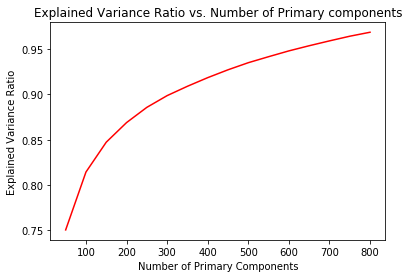

In [15]:
x=range(50,850,50)
plt.plot(x,expl_var_rt_list,c="red")
plt.xlabel("Number of Primary Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio vs. Number of Primary components")
#plt.legend()
plt.show()

We can see that 90% explaind varience is achieve for 300 primary components. This should be enough for proper features' representation so we will use this value n_components=300.


Now, let's plot the learning curve. The model will be run for different number of samples per class.

In [19]:
cost_list=[]
acc_test=[]
acc_train=[]
err_test=[]
err_train=[]
expl_var_rt_list=[]

------------------------------
Number of samples:  400
Expl variance for  300  components:  196.83
Expl variance ratio for  300  components:  0.96


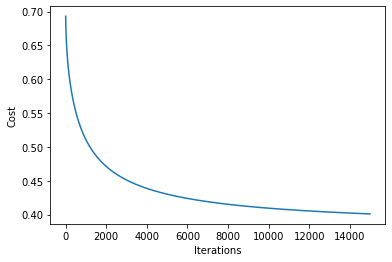

Error:  0.54

Confusion matrix: 
TP:  20  TN:  17
FP:  23  FN:  20

Accuracy =  0.46
Precision =  0.47
Recall =  0.5
F-score =  0.48

Train Accuracy:  [0.82]
Test Accuracy:  [0.46]
------------------------------
Number of samples:  1000
Expl variance for  300  components:  187.82
Expl variance ratio for  300  components:  0.92


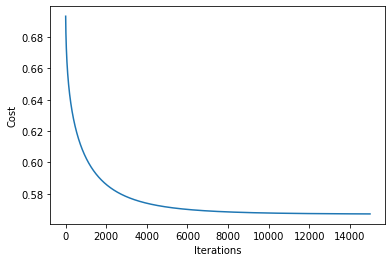

Error:  0.4

Confusion matrix: 
TP:  65  TN:  55
FP:  48  FN:  32

Accuracy =  0.6
Precision =  0.58
Recall =  0.67
F-score =  0.62

Train Accuracy:  [0.82, 0.71]
Test Accuracy:  [0.46, 0.6]
------------------------------
Number of samples:  1600
Expl variance for  300  components:  185.67
Expl variance ratio for  300  components:  0.91


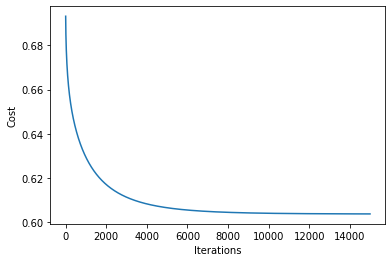

Error:  0.38

Confusion matrix: 
TP:  107  TN:  93
FP:  58  FN:  62

Accuracy =  0.62
Precision =  0.65
Recall =  0.63
F-score =  0.64

Train Accuracy:  [0.82, 0.71, 0.66]
Test Accuracy:  [0.46, 0.6, 0.62]
------------------------------
Number of samples:  2200
Expl variance for  300  components:  184.81
Expl variance ratio for  300  components:  0.91


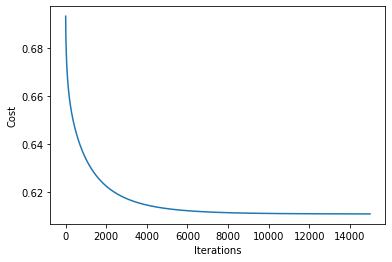

Error:  0.4

Confusion matrix: 
TP:  136  TN:  129
FP:  96  FN:  79

Accuracy =  0.6
Precision =  0.59
Recall =  0.63
F-score =  0.61

Train Accuracy:  [0.82, 0.71, 0.66, 0.67]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6]
------------------------------
Number of samples:  2800
Expl variance for  300  components:  185.11
Expl variance ratio for  300  components:  0.91


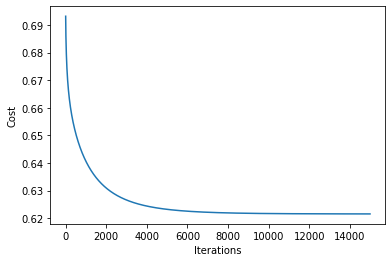

Error:  0.35

Confusion matrix: 
TP:  186  TN:  178
FP:  104  FN:  92

Accuracy =  0.65
Precision =  0.64
Recall =  0.67
F-score =  0.65

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65]
------------------------------
Number of samples:  3400
Expl variance for  300  components:  184.53
Expl variance ratio for  300  components:  0.91


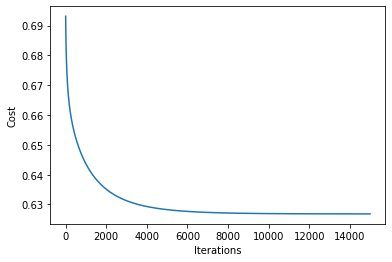

Error:  0.39

Confusion matrix: 
TP:  215  TN:  202
FP:  144  FN:  119

Accuracy =  0.61
Precision =  0.6
Recall =  0.64
F-score =  0.62

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61]
------------------------------
Number of samples:  4000
Expl variance for  300  components:  184.17
Expl variance ratio for  300  components:  0.9


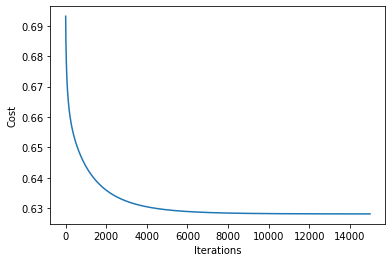

Error:  0.43

Confusion matrix: 
TP:  236  TN:  223
FP:  169  FN:  172

Accuracy =  0.57
Precision =  0.58
Recall =  0.58
F-score =  0.58

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57]
------------------------------
Number of samples:  4600
Expl variance for  300  components:  184.43
Expl variance ratio for  300  components:  0.9


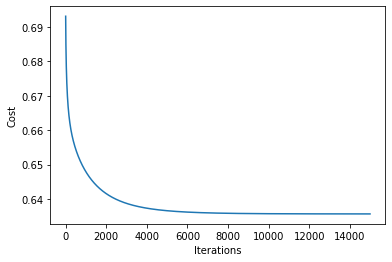

Error:  0.39

Confusion matrix: 
TP:  285  TN:  274
FP:  182  FN:  179

Accuracy =  0.61
Precision =  0.61
Recall =  0.61
F-score =  0.61

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65, 0.64]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57, 0.61]
------------------------------
Number of samples:  5200
Expl variance for  300  components:  183.47
Expl variance ratio for  300  components:  0.9


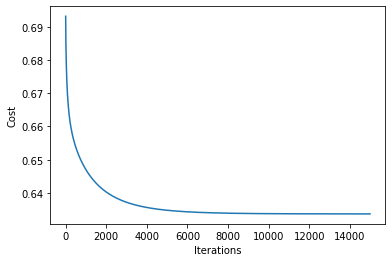

Error:  0.42

Confusion matrix: 
TP:  289  TN:  310
FP:  227  FN:  214

Accuracy =  0.58
Precision =  0.56
Recall =  0.57
F-score =  0.56

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65, 0.64, 0.64]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57, 0.61, 0.58]
------------------------------
Number of samples:  5800
Expl variance for  300  components:  183.7
Expl variance ratio for  300  components:  0.9


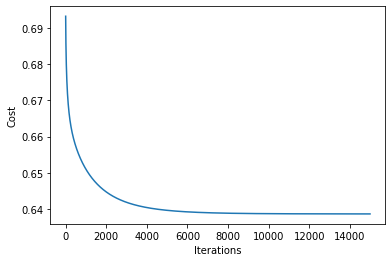

Error:  0.4

Confusion matrix: 
TP:  339  TN:  359
FP:  239  FN:  223

Accuracy =  0.6
Precision =  0.59
Recall =  0.6
F-score =  0.59

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65, 0.64, 0.64, 0.63]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57, 0.61, 0.58, 0.6]
------------------------------
Number of samples:  6400
Expl variance for  300  components:  183.69
Expl variance ratio for  300  components:  0.9


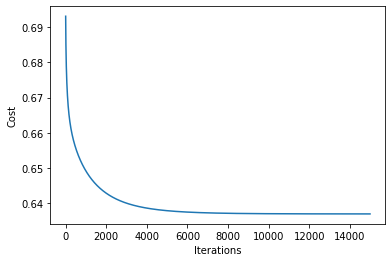

Error:  0.42

Confusion matrix: 
TP:  363  TN:  382
FP:  258  FN:  277

Accuracy =  0.58
Precision =  0.58
Recall =  0.57
F-score =  0.57

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.64]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57, 0.61, 0.58, 0.6, 0.58]
------------------------------
Number of samples:  7000
Expl variance for  300  components:  183.33
Expl variance ratio for  300  components:  0.9


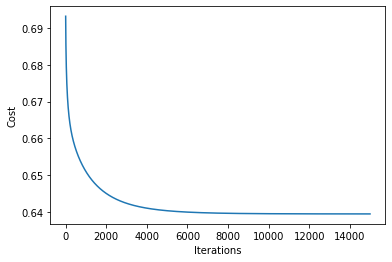

Error:  0.41

Confusion matrix: 
TP:  430  TN:  399
FP:  280  FN:  291

Accuracy =  0.59
Precision =  0.61
Recall =  0.6
F-score =  0.6

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.64, 0.63]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57, 0.61, 0.58, 0.6, 0.58, 0.59]
------------------------------
Number of samples:  7600
Expl variance for  300  components:  183.43
Expl variance ratio for  300  components:  0.9


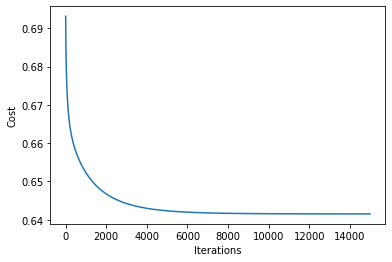

Error:  0.39

Confusion matrix: 
TP:  475  TN:  451
FP:  320  FN:  274

Accuracy =  0.61
Precision =  0.6
Recall =  0.63
F-score =  0.61

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.64, 0.63, 0.63]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57, 0.61, 0.58, 0.6, 0.58, 0.59, 0.61]
------------------------------
Number of samples:  8200
Expl variance for  300  components:  182.96
Expl variance ratio for  300  components:  0.9


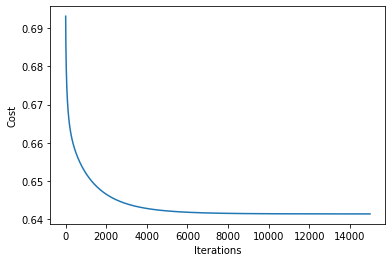

Error:  0.4

Confusion matrix: 
TP:  482  TN:  500
FP:  316  FN:  342

Accuracy =  0.6
Precision =  0.6
Recall =  0.58
F-score =  0.59

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.64, 0.63, 0.63, 0.64]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57, 0.61, 0.58, 0.6, 0.58, 0.59, 0.61, 0.6]
------------------------------
Number of samples:  8800
Expl variance for  300  components:  182.59
Expl variance ratio for  300  components:  0.9


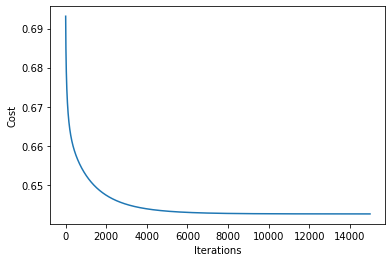

Error:  0.39

Confusion matrix: 
TP:  545  TN:  520
FP:  373  FN:  322

Accuracy =  0.61
Precision =  0.59
Recall =  0.63
F-score =  0.61

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.64, 0.63, 0.63, 0.64, 0.63]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57, 0.61, 0.58, 0.6, 0.58, 0.59, 0.61, 0.6, 0.61]
------------------------------
Number of samples:  9400
Expl variance for  300  components:  182.78
Expl variance ratio for  300  components:  0.9


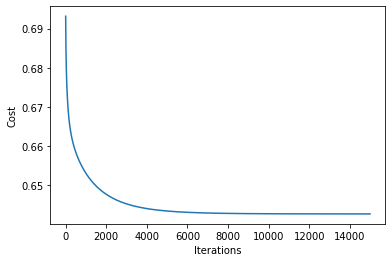

Error:  0.4

Confusion matrix: 
TP:  566  TN:  554
FP:  383  FN:  377

Accuracy =  0.6
Precision =  0.6
Recall =  0.6
F-score =  0.6

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.64, 0.63, 0.63, 0.64, 0.63, 0.63]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57, 0.61, 0.58, 0.6, 0.58, 0.59, 0.61, 0.6, 0.61, 0.6]
------------------------------
Number of samples:  10000
Expl variance for  300  components:  182.59
Expl variance ratio for  300  components:  0.9


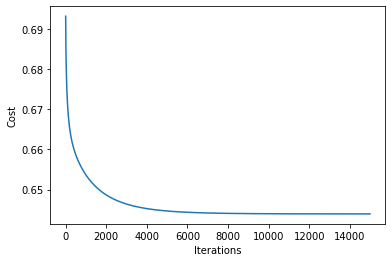

Error:  0.39

Confusion matrix: 
TP:  609  TN:  616
FP:  382  FN:  393

Accuracy =  0.61
Precision =  0.61
Recall =  0.61
F-score =  0.61

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.64, 0.63, 0.63, 0.64, 0.63, 0.63, 0.63]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57, 0.61, 0.58, 0.6, 0.58, 0.59, 0.61, 0.6, 0.61, 0.6, 0.61]
------------------------------
Number of samples:  10600
Expl variance for  300  components:  182.65
Expl variance ratio for  300  components:  0.9


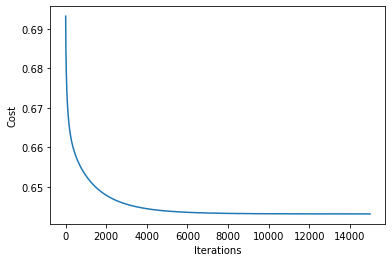

Error:  0.39

Confusion matrix: 
TP:  656  TN:  639
FP:  422  FN:  403

Accuracy =  0.61
Precision =  0.61
Recall =  0.62
F-score =  0.61

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.64, 0.63, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57, 0.61, 0.58, 0.6, 0.58, 0.59, 0.61, 0.6, 0.61, 0.6, 0.61, 0.61]
------------------------------
Number of samples:  11200
Expl variance for  300  components:  182.69
Expl variance ratio for  300  components:  0.9


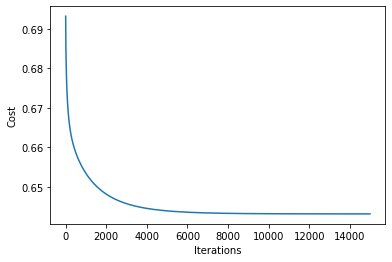

Error:  0.4

Confusion matrix: 
TP:  703  TN:  648
FP:  471  FN:  418

Accuracy =  0.6
Precision =  0.6
Recall =  0.63
F-score =  0.61

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.64, 0.63, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57, 0.61, 0.58, 0.6, 0.58, 0.59, 0.61, 0.6, 0.61, 0.6, 0.61, 0.61, 0.6]
------------------------------
Number of samples:  11800
Expl variance for  300  components:  182.89
Expl variance ratio for  300  components:  0.9


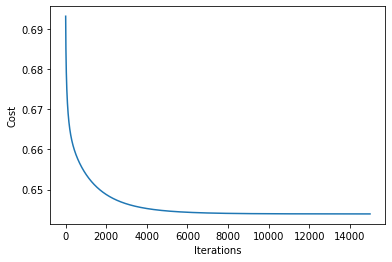

Error:  0.38

Confusion matrix: 
TP:  737  TN:  734
FP:  467  FN:  422

Accuracy =  0.62
Precision =  0.61
Recall =  0.64
F-score =  0.62

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.64, 0.63, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57, 0.61, 0.58, 0.6, 0.58, 0.59, 0.61, 0.6, 0.61, 0.6, 0.61, 0.61, 0.6, 0.62]
------------------------------
Number of samples:  12400
Expl variance for  300  components:  182.52
Expl variance ratio for  300  components:  0.9


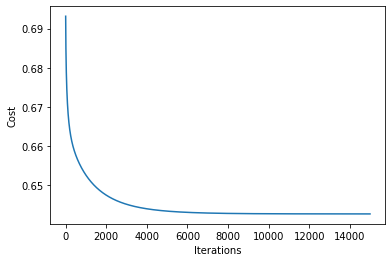

Error:  0.4

Confusion matrix: 
TP:  752  TN:  733
FP:  530  FN:  465

Accuracy =  0.6
Precision =  0.59
Recall =  0.62
F-score =  0.6

Train Accuracy:  [0.82, 0.71, 0.66, 0.67, 0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.64, 0.63, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.46, 0.6, 0.62, 0.6, 0.65, 0.61, 0.57, 0.61, 0.58, 0.6, 0.58, 0.59, 0.61, 0.6, 0.61, 0.6, 0.61, 0.61, 0.6, 0.62, 0.6]


In [20]:
image_size=32
#dataset_size=12500
n_components=300
alpha=0.02 #learning rate
num_iterations=15000
for i in range(400,12600,600):
    print ("-"*30)
    print ("Number of samples: ",i)
    
    dataset_size=i
    expl_var_rt,theta_trained=run_the_model(image_size,dataset_size,n_components,alpha,num_iterations)
    expl_var_rt_list.append(expl_var_rt)
    print ("Train Accuracy: ",acc_train)
    print ("Test Accuracy: ",acc_test)

Below the error in a different scale (0-1) is shown.

Expl variance for  300  components:  182.52
Expl variance ratio for  300  components:  0.9


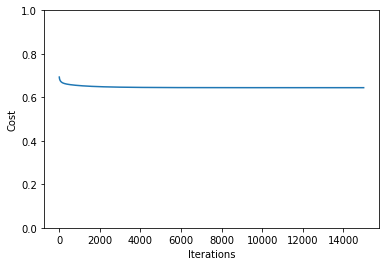

Error:  0.38

Confusion matrix: 
TP:  816  TN:  740
FP:  471  FN:  473

Accuracy =  0.62
Precision =  0.63
Recall =  0.63
F-score =  0.63

Train Accuracy:  [0.63]
Test Accuracy:  [0.62]


In [38]:
cost_list=[]
acc_test=[]
acc_train=[]
err_test=[]
err_train=[]
expl_var_rt_list=[]
image_size=32
#dataset_size=12500
n_components=300
alpha=0.02 #learning rate
num_iterations=15000
i = 12600
dataset_size=i
expl_var_rt,theta_trained=run_the_model(image_size,dataset_size,n_components,alpha,num_iterations)
expl_var_rt_list.append(expl_var_rt)
print ("Train Accuracy: ",acc_train)
print ("Test Accuracy: ",acc_test)

And here is the learning curve.

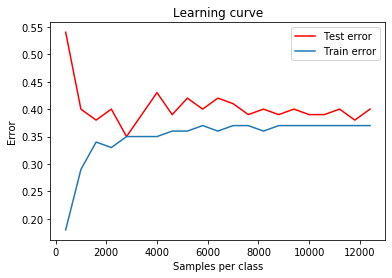

In [21]:
x=range(400,12600,600)
plt.plot(x,err_test,c="red",label="Test error")
plt.plot(x,err_train,label="Train error")
plt.xlabel("Samples per class")
plt.ylabel("Error")
plt.title("Learning curve")
plt.legend()
plt.show()

Now let's make experiments with image size 32x32 and 64x64 to see if it makes sense to import images with bigger size, will this give us a better test accuracy. We will make 15 iterations for accuracy calculation for both image sizes. Then we will do some analysis of the results.

In [22]:
cost_list=[]
acc_test=[]
acc_train=[]
err_test=[]
err_train=[]
expl_var_rt_list=[]

------------------------------
Iteration:  0
Expl variance for  300  components:  182.46
Expl variance ratio for  300  components:  0.9


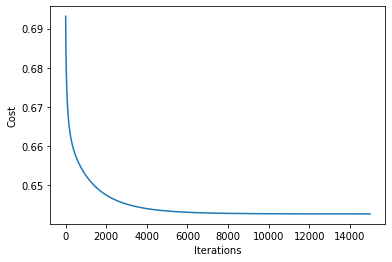

Error:  0.4

Confusion matrix: 
TP:  750  TN:  760
FP:  531  FN:  459

Accuracy =  0.6
Precision =  0.59
Recall =  0.62
F-score =  0.6

Train Accuracy:  [0.63]
Test Accuracy:  [0.6]
------------------------------
Iteration:  1
Expl variance for  300  components:  182.51
Expl variance ratio for  300  components:  0.9


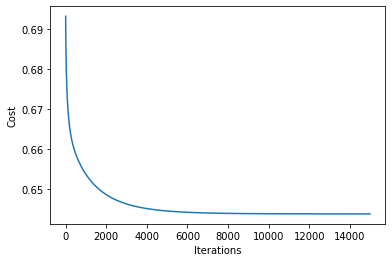

Error:  0.37

Confusion matrix: 
TP:  772  TN:  795
FP:  479  FN:  454

Accuracy =  0.63
Precision =  0.62
Recall =  0.63
F-score =  0.62

Train Accuracy:  [0.63, 0.63]
Test Accuracy:  [0.6, 0.63]
------------------------------
Iteration:  2
Expl variance for  300  components:  182.27
Expl variance ratio for  300  components:  0.9


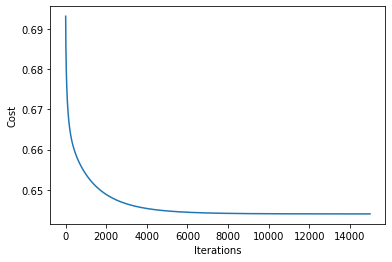

Error:  0.39

Confusion matrix: 
TP:  764  TN:  773
FP:  506  FN:  457

Accuracy =  0.61
Precision =  0.6
Recall =  0.63
F-score =  0.61

Train Accuracy:  [0.63, 0.63, 0.63]
Test Accuracy:  [0.6, 0.63, 0.61]
------------------------------
Iteration:  3
Expl variance for  300  components:  182.26
Expl variance ratio for  300  components:  0.9


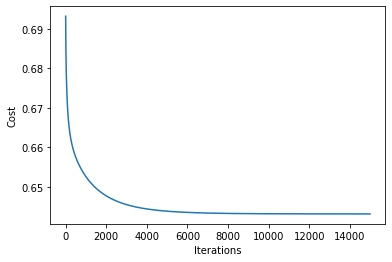

Error:  0.4

Confusion matrix: 
TP:  785  TN:  708
FP:  516  FN:  491

Accuracy =  0.6
Precision =  0.6
Recall =  0.62
F-score =  0.61

Train Accuracy:  [0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.6, 0.63, 0.61, 0.6]
------------------------------
Iteration:  4
Expl variance for  300  components:  182.26
Expl variance ratio for  300  components:  0.9


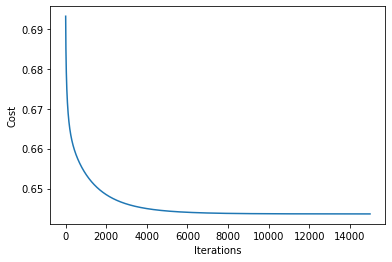

Error:  0.4

Confusion matrix: 
TP:  771  TN:  722
FP:  534  FN:  473

Accuracy =  0.6
Precision =  0.59
Recall =  0.62
F-score =  0.6

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.6, 0.63, 0.61, 0.6, 0.6]
------------------------------
Iteration:  5
Expl variance for  300  components:  182.43
Expl variance ratio for  300  components:  0.9


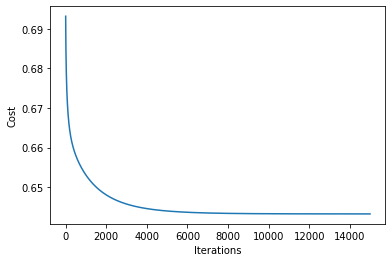

Error:  0.38

Confusion matrix: 
TP:  787  TN:  754
FP:  505  FN:  454

Accuracy =  0.62
Precision =  0.61
Recall =  0.63
F-score =  0.62

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.6, 0.63, 0.61, 0.6, 0.6, 0.62]
------------------------------
Iteration:  6
Expl variance for  300  components:  182.37
Expl variance ratio for  300  components:  0.9


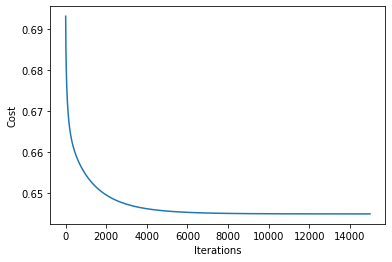

Error:  0.38

Confusion matrix: 
TP:  798  TN:  756
FP:  472  FN:  474

Accuracy =  0.62
Precision =  0.63
Recall =  0.63
F-score =  0.63

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.6, 0.63, 0.61, 0.6, 0.6, 0.62, 0.62]
------------------------------
Iteration:  7
Expl variance for  300  components:  182.31
Expl variance ratio for  300  components:  0.9


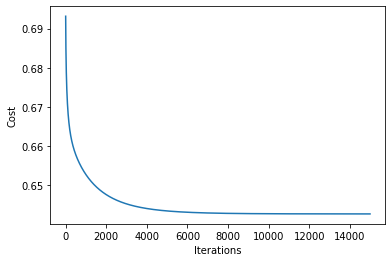

Error:  0.39

Confusion matrix: 
TP:  772  TN:  748
FP:  526  FN:  454

Accuracy =  0.61
Precision =  0.59
Recall =  0.63
F-score =  0.61

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64]
Test Accuracy:  [0.6, 0.63, 0.61, 0.6, 0.6, 0.62, 0.62, 0.61]
------------------------------
Iteration:  8
Expl variance for  300  components:  182.55
Expl variance ratio for  300  components:  0.9


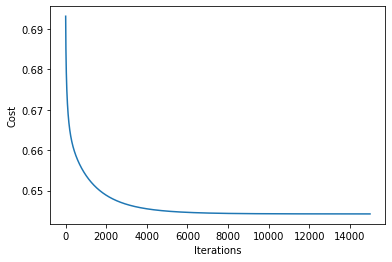

Error:  0.39

Confusion matrix: 
TP:  777  TN:  758
FP:  503  FN:  462

Accuracy =  0.61
Precision =  0.61
Recall =  0.63
F-score =  0.62

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64, 0.63]
Test Accuracy:  [0.6, 0.63, 0.61, 0.6, 0.6, 0.62, 0.62, 0.61, 0.61]
------------------------------
Iteration:  9
Expl variance for  300  components:  182.5
Expl variance ratio for  300  components:  0.9


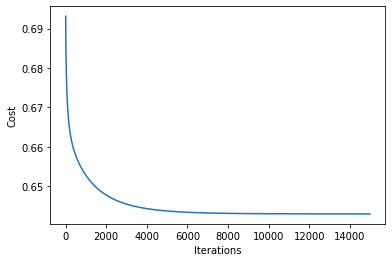

Error:  0.39

Confusion matrix: 
TP:  766  TN:  756
FP:  517  FN:  461

Accuracy =  0.61
Precision =  0.6
Recall =  0.62
F-score =  0.61

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64, 0.63, 0.63]
Test Accuracy:  [0.6, 0.63, 0.61, 0.6, 0.6, 0.62, 0.62, 0.61, 0.61, 0.61]
------------------------------
Iteration:  10
Expl variance for  300  components:  182.5
Expl variance ratio for  300  components:  0.9


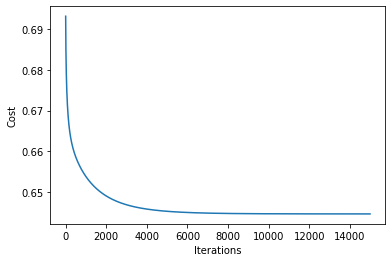

Error:  0.39

Confusion matrix: 
TP:  804  TN:  714
FP:  481  FN:  501

Accuracy =  0.61
Precision =  0.63
Recall =  0.62
F-score =  0.62

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64, 0.63, 0.63, 0.63]
Test Accuracy:  [0.6, 0.63, 0.61, 0.6, 0.6, 0.62, 0.62, 0.61, 0.61, 0.61, 0.61]
------------------------------
Iteration:  11
Expl variance for  300  components:  182.56
Expl variance ratio for  300  components:  0.9


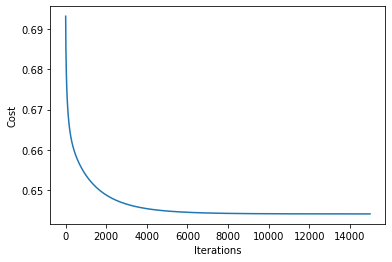

Error:  0.37

Confusion matrix: 
TP:  815  TN:  751
FP:  476  FN:  458

Accuracy =  0.63
Precision =  0.63
Recall =  0.64
F-score =  0.63

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.6, 0.63, 0.61, 0.6, 0.6, 0.62, 0.62, 0.61, 0.61, 0.61, 0.61, 0.63]
------------------------------
Iteration:  12
Expl variance for  300  components:  182.38
Expl variance ratio for  300  components:  0.9


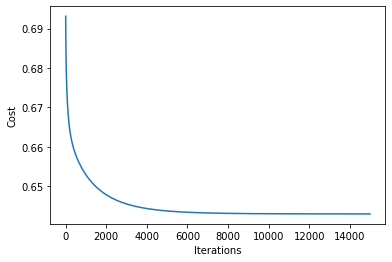

Error:  0.38

Confusion matrix: 
TP:  783  TN:  758
FP:  519  FN:  440

Accuracy =  0.62
Precision =  0.6
Recall =  0.64
F-score =  0.62

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.6, 0.63, 0.61, 0.6, 0.6, 0.62, 0.62, 0.61, 0.61, 0.61, 0.61, 0.63, 0.62]
------------------------------
Iteration:  13
Expl variance for  300  components:  182.44
Expl variance ratio for  300  components:  0.9


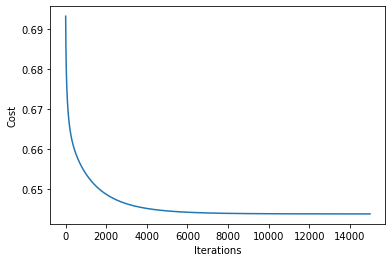

Error:  0.4

Confusion matrix: 
TP:  759  TN:  741
FP:  520  FN:  480

Accuracy =  0.6
Precision =  0.59
Recall =  0.61
F-score =  0.6

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.6, 0.63, 0.61, 0.6, 0.6, 0.62, 0.62, 0.61, 0.61, 0.61, 0.61, 0.63, 0.62, 0.6]
------------------------------
Iteration:  14
Expl variance for  300  components:  182.46
Expl variance ratio for  300  components:  0.9


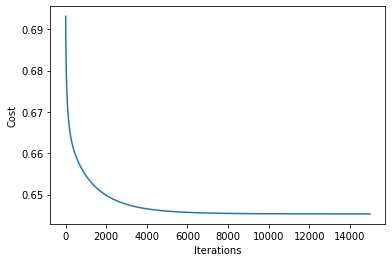

Error:  0.37

Confusion matrix: 
TP:  801  TN:  763
FP:  476  FN:  460

Accuracy =  0.63
Precision =  0.63
Recall =  0.64
F-score =  0.63

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.6, 0.63, 0.61, 0.6, 0.6, 0.62, 0.62, 0.61, 0.61, 0.61, 0.61, 0.63, 0.62, 0.6, 0.63]


In [23]:
image_size=32
#dataset_size=12500
n_components=300
alpha=0.02 #learning rate
num_iterations=15000
dataset_size=12500
for i in range(15):
    print ("-"*30)
    print ("Iteration: ",i)
    
    expl_var_rt,theta_trained=run_the_model(image_size,dataset_size,n_components,alpha,num_iterations)
    expl_var_rt_list.append(expl_var_rt)
    print ("Train Accuracy: ",acc_train)
    print ("Test Accuracy: ",acc_test)

In [29]:
acc_test_32=acc_test

In [30]:
cost_list=[]
acc_test=[]
acc_train=[]
err_test=[]
err_train=[]
expl_var_rt_list=[]

------------------------------
Iteration:  0
Expl variance for  300  components:  716.74
Expl variance ratio for  300  components:  0.88


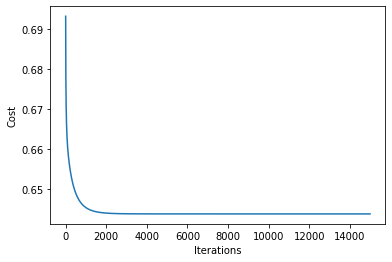

Error:  0.37

Confusion matrix: 
TP:  796  TN:  767
FP:  471  FN:  466

Accuracy =  0.63
Precision =  0.63
Recall =  0.63
F-score =  0.63

Train Accuracy:  [0.63]
Test Accuracy:  [0.63]
------------------------------
Iteration:  1
Expl variance for  300  components:  716.52
Expl variance ratio for  300  components:  0.88


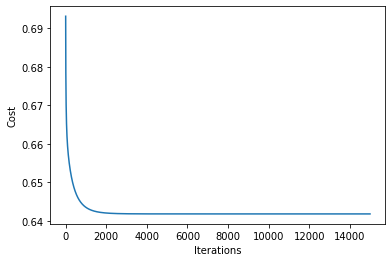

Error:  0.4

Confusion matrix: 
TP:  759  TN:  752
FP:  493  FN:  496

Accuracy =  0.6
Precision =  0.61
Recall =  0.6
F-score =  0.6

Train Accuracy:  [0.63, 0.63]
Test Accuracy:  [0.63, 0.6]
------------------------------
Iteration:  2
Expl variance for  300  components:  715.63
Expl variance ratio for  300  components:  0.88


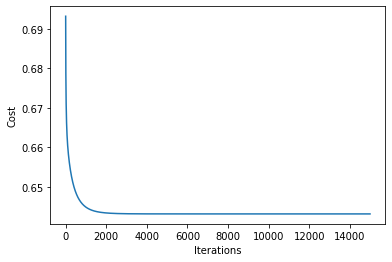

Error:  0.38

Confusion matrix: 
TP:  803  TN:  747
FP:  495  FN:  455

Accuracy =  0.62
Precision =  0.62
Recall =  0.64
F-score =  0.63

Train Accuracy:  [0.63, 0.63, 0.63]
Test Accuracy:  [0.63, 0.6, 0.62]
------------------------------
Iteration:  3
Expl variance for  300  components:  717.74
Expl variance ratio for  300  components:  0.88


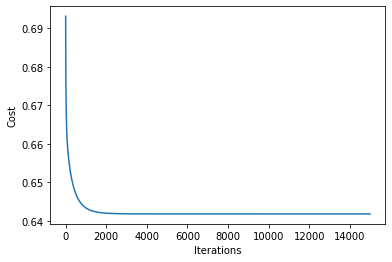

Error:  0.4

Confusion matrix: 
TP:  772  TN:  729
FP:  518  FN:  481

Accuracy =  0.6
Precision =  0.6
Recall =  0.62
F-score =  0.61

Train Accuracy:  [0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.63, 0.6, 0.62, 0.6]
------------------------------
Iteration:  4
Expl variance for  300  components:  716.07
Expl variance ratio for  300  components:  0.88


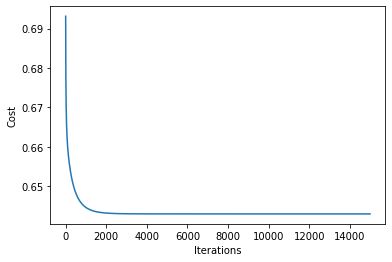

Error:  0.39

Confusion matrix: 
TP:  774  TN:  747
FP:  499  FN:  480

Accuracy =  0.61
Precision =  0.61
Recall =  0.62
F-score =  0.61

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.63, 0.6, 0.62, 0.6, 0.61]
------------------------------
Iteration:  5
Expl variance for  300  components:  717.96
Expl variance ratio for  300  components:  0.88


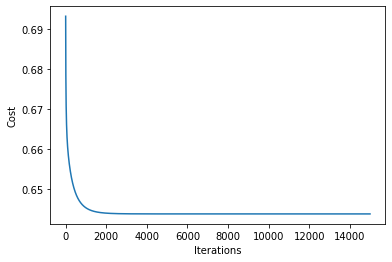

Error:  0.37

Confusion matrix: 
TP:  787  TN:  789
FP:  475  FN:  449

Accuracy =  0.63
Precision =  0.62
Recall =  0.64
F-score =  0.63

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.63, 0.6, 0.62, 0.6, 0.61, 0.63]
------------------------------
Iteration:  6
Expl variance for  300  components:  716.75
Expl variance ratio for  300  components:  0.88


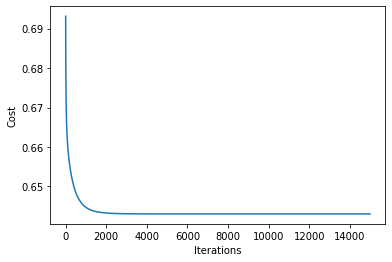

Error:  0.38

Confusion matrix: 
TP:  768  TN:  784
FP:  476  FN:  472

Accuracy =  0.62
Precision =  0.62
Recall =  0.62
F-score =  0.62

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.63, 0.6, 0.62, 0.6, 0.61, 0.63, 0.62]
------------------------------
Iteration:  7
Expl variance for  300  components:  717.18
Expl variance ratio for  300  components:  0.88


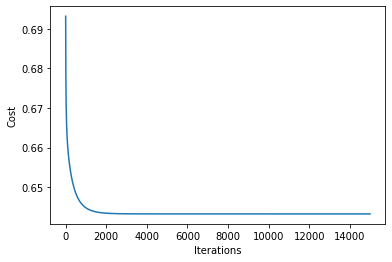

Error:  0.39

Confusion matrix: 
TP:  795  TN:  737
FP:  517  FN:  451

Accuracy =  0.61
Precision =  0.61
Recall =  0.64
F-score =  0.62

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.63, 0.6, 0.62, 0.6, 0.61, 0.63, 0.62, 0.61]
------------------------------
Iteration:  8
Expl variance for  300  components:  719.04
Expl variance ratio for  300  components:  0.88


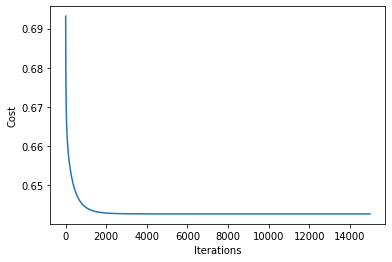

Error:  0.39

Confusion matrix: 
TP:  787  TN:  747
FP:  513  FN:  453

Accuracy =  0.61
Precision =  0.61
Recall =  0.63
F-score =  0.62

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.63, 0.6, 0.62, 0.6, 0.61, 0.63, 0.62, 0.61, 0.61]
------------------------------
Iteration:  9
Expl variance for  300  components:  716.49
Expl variance ratio for  300  components:  0.88


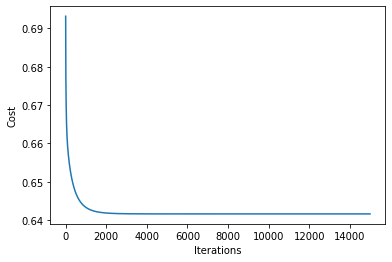

Error:  0.4

Confusion matrix: 
TP:  762  TN:  739
FP:  502  FN:  497

Accuracy =  0.6
Precision =  0.6
Recall =  0.61
F-score =  0.6

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.63, 0.6, 0.62, 0.6, 0.61, 0.63, 0.62, 0.61, 0.61, 0.6]
------------------------------
Iteration:  10
Expl variance for  300  components:  716.78
Expl variance ratio for  300  components:  0.88


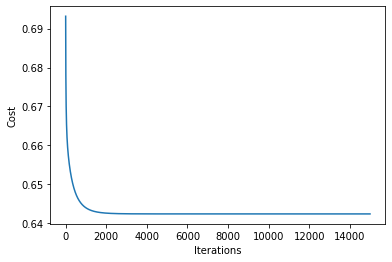

Error:  0.39

Confusion matrix: 
TP:  769  TN:  766
FP:  498  FN:  467

Accuracy =  0.61
Precision =  0.61
Recall =  0.62
F-score =  0.61

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.63, 0.6, 0.62, 0.6, 0.61, 0.63, 0.62, 0.61, 0.61, 0.6, 0.61]
------------------------------
Iteration:  11
Expl variance for  300  components:  717.28
Expl variance ratio for  300  components:  0.88


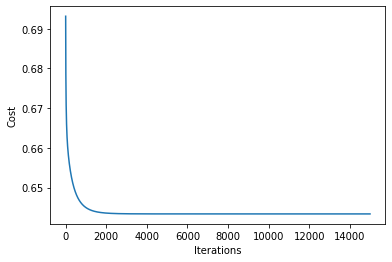

Error:  0.37

Confusion matrix: 
TP:  807  TN:  768
FP:  462  FN:  463

Accuracy =  0.63
Precision =  0.64
Recall =  0.64
F-score =  0.64

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.63, 0.6, 0.62, 0.6, 0.61, 0.63, 0.62, 0.61, 0.61, 0.6, 0.61, 0.63]
------------------------------
Iteration:  12
Expl variance for  300  components:  717.18
Expl variance ratio for  300  components:  0.88


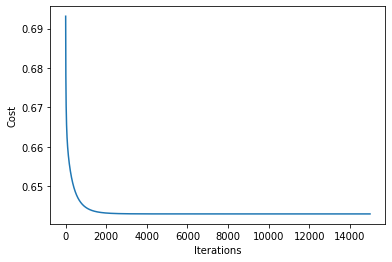

Error:  0.39

Confusion matrix: 
TP:  784  TN:  748
FP:  482  FN:  486

Accuracy =  0.61
Precision =  0.62
Recall =  0.62
F-score =  0.62

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.63, 0.6, 0.62, 0.6, 0.61, 0.63, 0.62, 0.61, 0.61, 0.6, 0.61, 0.63, 0.61]
------------------------------
Iteration:  13
Expl variance for  300  components:  718.32
Expl variance ratio for  300  components:  0.88


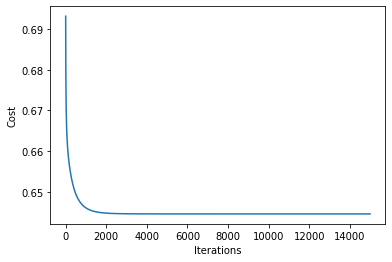

Error:  0.36

Confusion matrix: 
TP:  798  TN:  791
FP:  468  FN:  443

Accuracy =  0.64
Precision =  0.63
Recall =  0.64
F-score =  0.63

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.63, 0.6, 0.62, 0.6, 0.61, 0.63, 0.62, 0.61, 0.61, 0.6, 0.61, 0.63, 0.61, 0.64]
------------------------------
Iteration:  14
Expl variance for  300  components:  715.91
Expl variance ratio for  300  components:  0.88


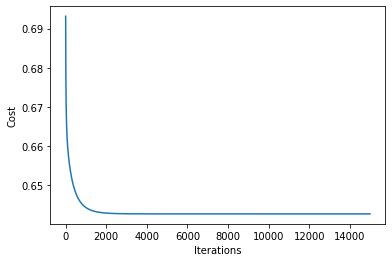

Error:  0.38

Confusion matrix: 
TP:  791  TN:  768
FP:  515  FN:  426

Accuracy =  0.62
Precision =  0.61
Recall =  0.65
F-score =  0.63

Train Accuracy:  [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Test Accuracy:  [0.63, 0.6, 0.62, 0.6, 0.61, 0.63, 0.62, 0.61, 0.61, 0.6, 0.61, 0.63, 0.61, 0.64, 0.62]


In [31]:
image_size=64
dataset_size=12500
n_components=300
alpha=0.02 #learning rate
num_iterations=15000

for i in range(15):
    print ("-"*30)
    print ("Iteration: ",i)
    
    expl_var_rt,theta_trained=run_the_model(image_size,dataset_size,n_components,alpha,num_iterations)
    expl_var_rt_list.append(expl_var_rt)
    print ("Train Accuracy: ",acc_train)
    print ("Test Accuracy: ",acc_test)

In [32]:
acc_test_64=acc_test

In [33]:
np.mean(acc_test_32)

0.614

In [34]:
np.mean(acc_test_64)

0.616

The mean value of the accuracy in second test with picture size 64x64 seems little bit higher, but not significantly higher. Let's check this statistically.

We make our set of hypothesises:

$H_0:$ - there is no significant difference in the mean values of the accuracy

$H_1:$ - there is significant difference in the mean values of the accuracy

For checking them we will use independent T test. We choose $\alpha_c$=5%

In [35]:
st.ttest_ind(acc_test_32,acc_test_64)

Ttest_indResult(statistic=-0.4885042104591972, pvalue=0.6289969454317694)

The p-value (62.9 %) is much higher than $\alpha_{c}$ which means we cannot reject the null hypothesis for this data. So, we assume there is no significant difference in the test accuracy in both experiments. Hence, no use of importing pictures with 64x64 size, we will stick to 32x32.



## Comparison with scikit-learn

In [39]:
image_size=32
temp_size=12500
n_components=300
cats,dogs=import_pictures(image_size)
X_train,X_test,y_train,y_test,expl_var_rt=take_data_subset(dataset_size,cats,dogs,n_components)

Expl variance for  300  components:  182.62
Expl variance ratio for  300  components:  0.9


In [40]:
log_reg= LogisticRegression(C=10,penalty="l2",solver="liblinear")
log_reg.fit(X_train,y_train)
print("test accuracy: {} ".format(log_reg.fit(X_test, y_test).score(X_test, y_test)))
print("train accuracy: {} ".format(log_reg.fit(X_train, y_train).score(X_train, y_train)))

C:\Users\mbararova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mbararova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test accuracy: 0.694 


C:\Users\mbararova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train accuracy: 0.6331111111111111 


The train accuracy (63.31 %) is same as of the presented model. Strangely, the test accuracy (69.4 %)is higher. This can be due to some accidential train/test splitting or due to the low ratio of test data (10 %).

## Future work

This model can be further developed into multi-class classification model. For example an application can be made for classification/recognizing mushrooms. Though, with this level of accuracy, I wouldn't trust it to tell me which mushroom is poisonous and which is not :) But can be a valuable exercise.   

And finally, everything put together.

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import cv2
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import os
import scipy.stats as st


# this is the folder with training data which is labeled

training_folder='C:/SU/Project/dogs-vs-cats/train/'

# folder with unlabeled test data

test_folder='C:/SU/Project/dogs-vs-cats/test1/'


def import_pictures(image_size):

    
    cat_images=[]
    dog_images=[]

    for file in os.listdir(training_folder):
        if 'cat' in file:
            
            img_cat=cv2.imread(training_folder+str(file),cv2.IMREAD_COLOR)
            img_cat_resized=cv2.resize(img_cat,(image_size,image_size)).flatten()/255
            img_cat_labeled=np.append(img_cat_resized,1)
            cat_images.append(img_cat_labeled)
        
        if 'dog' in file:
        
            img_dog=cv2.imread(training_folder+str(file),cv2.IMREAD_COLOR)
            img_dog_resized=cv2.resize(img_dog,(image_size,image_size)).flatten()/255
            img_dog_labeled=np.append(img_dog_resized,0)
            dog_images.append(img_dog_labeled)
    
    cat_images=np.array(cat_images)
    dog_images=np.array(dog_images)
    
    return cat_images,dog_images


def take_data_subset(temp_size,cat_images,dog_images,n_components):
    
    #temp_size is the number of pictures (samples) to be taken from the set
    
    temp_cat=cat_images[:temp_size,:]
    temp_dog=dog_images[:temp_size,:]
    temp_training_set=np.concatenate((temp_cat,temp_dog),axis=0)
     
    np.random.shuffle(temp_training_set)
        
    X_train,X_test,y_train,y_test,expl_var_rt=apply_PCA(temp_training_set,n_components) # apply_PCA function is defined and explained little bit later
        
    return X_train,X_test,y_train,y_test,expl_var_rt


def sigmoid(z):
    return 1/(1+(np.power((np.e),-z)))



def gradient_descent(theta,X_train,y_train,alpha,num_iterations):
    
    
    cost_list=[]
    cost=0
    
    lmbda=0.1
    
    for iteration in range(num_iterations):
        
        hypothesis=sigmoid(np.dot(X_train,theta))
        nb_samples=X_train.shape[0]
        cost+=np.sum((y_train*np.log(hypothesis+0.00000001)+(1-y_train)*np.log(1-hypothesis+0.00000001)))
        
        cost=-cost/nb_samples
        cost_list.append(cost)
        theta1=theta
        theta1[0]=0
        
        derivative=(1/nb_samples)*(np.dot(X_train.T,(hypothesis-y_train))) +(lmbda/nb_samples)*theta1
         
        theta=theta-alpha*derivative
       
        #print (iteration,":",cost)   
    x=np.arange(num_iterations)
    plt.plot(x,cost_list)
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.show()
    
    return (theta,cost)


def apply_PCA(temp_training_set,n_components):
    
    
    X=temp_training_set[:,:-1]
    y=np.array([temp_training_set[:,-1]]).T
    
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.10,random_state=42)
    
    
    pca=decomposition.PCA(n_components)
    
    # the pca is fit only to the training set, otherwise it will "see" the test set
    # after that transform is applied to both trainigna nd test sets
    
    pca.fit(X_train)
    pca_temp_training_set=pca.transform(X_train)
    pca_temp_test_set=pca.transform(X_test)
    
    
    print ("Expl variance for ",n_components," components: ",round(np.sum(pca.explained_variance_),2))
    print ("Expl variance ratio for ",n_components," components: ",round(np.sum(pca.explained_variance_ratio_),2))
        
    
    #pca_temp_set_final=np.concatenate((pca_temp_training_set,pca_temp_test_set),axis=0)
    
    ones_vector=np.ones((pca_temp_training_set.shape[0],1))
    pca_temp_training_set=np.c_[ones_vector, pca_temp_training_set]  
    
    ones_vector=np.ones((pca_temp_test_set.shape[0],1))
    pca_temp_test_set=np.c_[ones_vector, pca_temp_test_set]  

    #pca_temp_set_final=np.c_[ones_vector, pca_temp_set_final]  
    
    expl_var_rt=np.sum(pca.explained_variance_ratio_)
   
    return pca_temp_training_set,pca_temp_test_set,y_train,y_test,expl_var_rt
    


def predict(theta_trained,X_test):
    
    hypothesis=np.dot(X_test,theta_trained)
    y_predicted=sigmoid(hypothesis)
    y_predicted_res=[1 if i>=0.5 else 0 for i in y_predicted]
    
    return y_predicted_res



def run_the_model(image_size,dataset_size,n_components,alpha,num_iterations):
    
   
    cats,dogs=import_pictures(image_size)
    X_train,X_test,y_train,y_test,expl_var_rt=take_data_subset(dataset_size,cats,dogs,n_components)
   
    theta=np.zeros([X_train.shape[1],1]) #initializing theta
    
    theta_trained,cost=gradient_descent(theta,X_train,y_train,alpha,num_iterations)
    
    cost_list.append(cost) #appending the cost value at each iteration
    
    y_predicted_test=predict(theta_trained,X_test) # predicting y with the test set
    y_predicted_train=predict(theta_trained,X_train) #prdicting y with the training set
    
    
    acc_test.append(round(metrics.accuracy_score(y_predicted_test,y_test),2))
    acc_train.append(round(metrics.accuracy_score(y_predicted_train,y_train),2))
    err_test.append(round(1-metrics.accuracy_score(y_predicted_test,y_test),2))
    err_train.append(round(1-metrics.accuracy_score(y_predicted_train,y_train),2))
    
    #calculating the confusion matrix and related metrics
    
    TP=np.sum(np.logical_and(np.array([y_predicted_test]).T==1,y_test==1))
    TN=np.sum(np.logical_and(np.array([y_predicted_test]).T==0,y_test==0))
    FP=np.sum(np.logical_and(np.array([y_predicted_test]).T==1,y_test==0))
    FN=np.sum(np.logical_and(np.array([y_predicted_test]).T==0,y_test==1))
    
    Accuracy=round((TP+TN)/(TP+TN+FP+FN),2)
    Precision=round(TP/(TP+FP),2)
    Recall=round(TP/(TP+FN),2)
    F_score=round(2*Precision*Recall/(Precision+Recall),2)
    
    print ("Error: ",round(1-metrics.accuracy_score(y_predicted_test,y_test),2))
    print ()
    print ("Confusion matrix: ")
    print ("TP: ",TP," TN: ",TN)
    
    print ("FP: ",FP," FN: ",FN)
    print ()
    print ("Accuracy = ", Accuracy)
    print ("Precision = ", Precision)
    print ("Recall = ", Recall)
    print ("F-score = ", F_score)
    print ()
    
    return expl_var_rt,theta_trained




cost_list=[]
acc_test=[]
acc_train=[]
err_test=[]
err_train=[]
expl_var_rt_list=[]

image_size=32
#dataset_size=12500
n_components=300
alpha=0.02 #learning rate
num_iterations=15000
for i in range(12500,12600,100):
    print ("-"*30)
    print ("Number of samples: ",i)
    
    dataset_size=i
    expl_var_rt,theta_trained=run_the_model(image_size,dataset_size,n_components,alpha,num_iterations)
    expl_var_rt_list.append(expl_var_rt)
    print ("Train Accuracy: ",acc_train)
    print ("Test Accuracy: ",acc_test)


### References:
    
    [1] John Paul Mueller, Luca Massaron. Machine Learning (in Python and R) for Dummies.John Wiley & Sons, 2018.
    [2] Aurelien Geron. Hands-on Mashine Learning with Scikit-Learn and TensorFlow. O'Reily, 2017.
    [3] Andrew Ng. Machine Learning. Coursera course.
    [4] Yordan Darakchiev. SoftUni "Mathematics for Developers" course, Linear algebra exercise, 2020.
    [5] Steven S. Skiena. The Data Science Design Manual. Springer,2017.
    [6] John Paul Mueller, Luca Massaron. Python for Data Science for Dummies. John Wiley & Sons, 2018.
    [7] Laura Igual, Santi Segui. Introduction to Data Science. Springer, 2017.